In [98]:
import folium
import zipfile
import io
from fastkml import kml
import pandas as pd
from io import StringIO
import csv
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import pyvista as pv
pv.set_jupyter_backend('client')

import py3dep

In [4]:
# read KML content 
kmz = zipfile.ZipFile("qfaults.kmz", 'r')  # extract zip file first, then read kmz file inside the extracted folder
kml_content = kmz.open('doc.kml', 'r').read()  # kml content
k = kml.KML()
k.from_string(kml_content)

In [5]:
docs = list(k.features())
folders=[]
for d in docs:
    folders.extend(list(d.features()))
records = []
for f in folders:
    records.extend(list(f.features()))
geoms = [element.geometry for element in records]

In [6]:
# print(dir(folders[0]))
print(folders[0].name)
print(folders[0].id)

Historical (150 years)
FeatureLayer0


In [8]:
names = [element.name for element in records]
print(len(set(names)))
print(len(names))

2107
112527


In [9]:
def get_header(record):
    tables = pd.read_html(StringIO(str(record.description)))
    data_table = list(tables[1][0])
    return data_table

def read_record(record):
    tables = pd.read_html(StringIO(str(record.description)))
    data_table = list(tables[1][1])
    return data_table

def get_all_data(record):
    data = []
    data.append(record.name)
    data.append(record.id)
    data.extend(read_record(record))
    data.append(record.geometry.wkt)
    return data

def get_all_headers(record):
    data = []
    data.append("Name")
    data.append("ID")
    data.extend(get_header(record))
    data.append("Geom")
    return data

print(get_all_headers(records[0]))
print(get_all_data(records[0]))
# headers = [len(get_header(element)) for element in records]

['Name', 'ID', 'Fault Name', 'Section Name', 'Fault ID', 'Section ID', 'Location', 'Linetype', 'Age', 'Dip Direction', 'Slip Rate(mm/year)', 'Slip Sense', 'Mapped Scale', 'Fault Class', 'Mapping Certainty', 'Average Strike', 'Total Fault Length (km)', 'Cooperator', 'Associated Earthquake', 'Date of Last Review', 'Fault url', 'symbology', 'Citation ID', 'Fault ID Number', 'Geom']
['San Andreas fault zone', 'ID_00000', 'San Andreas fault zone', 'Shelter Cove Section', '1', 'a', 'California', 'Inferred', 'historic', 'Vertical', 'Greater than 5.0 mm/yr', 'Right lateral', 'unspecified', 'A', 'Good', 'N12°W', '1082', 'California Geological Survey', 'San Francisco earthquake', '12/10/2002', 'https://earthquake.usgs.gov/cfusion/qfault/show_report_AB_archive.cfm?fault_id=1&section_id=a', 'historic Inferred', '1a', '1', 'MULTILINESTRING((-124.090694000324 40.11756400000441 0.0, -124.0905649995543 40.11569200027037 0.0, -124.0904559997744 40.11512000009119 0.0, -124.0901240004117 40.1146650003225

In [10]:
geoms = [element.geometry for element in records]  # extract geometry
# dir(geoms[0])

In [ ]:
filename = 'Qfaults.csv'
with open(filename, 'w', newline="") as file:
    csvwriter = csv.writer(file)
    header = get_all_headers(records[0])
    csvwriter.writerow(header)
    for record in tqdm (records, desc="Writing File..."):
        data = get_all_data(record)
        csvwriter.writerow(data)
    # csvwriter.writerows(data) # 5. write the rest of the data

In [11]:
filter_name = "Calaveras fault zone"
filtered_records = list(filter(lambda record: (record.name == filter_name), records))  
filtered_records = list(map(get_all_data, filtered_records))
filtered_records = list(filter(lambda record: (record[8] == "historic"), filtered_records))  
# pv.Cone().plot()

In [162]:
def get_points(record):
    #last is lat,long
    multi_line_string = record[-1][17:-2]
    # MULTILINESTRING((-121.5036249996688 37.03746799973482 0.0, -121.503775000355 37.03769099972591 0.0))
    points = multi_line_string.split(',')
    lat_longs = []
    for point in points:
        lat_longs.append([float(x) for x in point.split(" ") if x]) #removes empty string
    lat_longs = np.array(lat_longs)
    return lat_longs
    # print(f"{lat_longs.shape}")


def get_cartesian(lat=None,lon=None,R = 6371,diff=0): #in km:
    # lat, lon = np.deg2rad(lat), np.deg2rad(lon)
    # R = 6371 # radius of the earth
    R = R + diff
    x = R * np.cos(lat) * np.cos(lon)
    y = R * np.cos(lat) * np.sin(lon)
    z = R *np.sin(lat)
    return np.vstack((x,y,z)).T

all_points = get_points(filtered_records[4])
# print(all_points)
all_cartesian = get_cartesian(all_points[:,0],all_points[:,1])
print(all_cartesian.shape)

(5, 3)


In [22]:
def create_wall(lat_longs,diff=1,R = 6371,connectivity_delta=0):
    all_cartesian_top = get_cartesian(lat_longs[:,0],lat_longs[:,1],R+diff)
    all_cartesian_bottom = get_cartesian(lat_longs[:,0],lat_longs[:,1],R-diff)
    number_of_points,dim = all_cartesian_top.shape
    assert(dim==3)
    connectivity = []
    for i in range(number_of_points-1):
        current_top=i+connectivity_delta
        next_top=i+1+connectivity_delta
        current_bottom=number_of_points+i+connectivity_delta
        next_bottom=number_of_points+i+1+connectivity_delta
        connectivity.extend([4,current_top,next_top,next_bottom,current_bottom])
    return np.vstack((all_cartesian_top,all_cartesian_bottom)),connectivity

def get_center(vertices):
    return np.average(vertices,axis=0)

def center_points(vertices):
    center = get_center(vertices)
    # print(vertices-center)
    return vertices-center

In [14]:
for i in range(len(filtered_records)):
    record = filtered_records[i]
    points = get_points(record)
    print(f"{i} {points.shape}")

0 (2, 3)
1 (2, 3)
2 (3, 3)
3 (3, 3)
4 (5, 3)
5 (2, 3)
6 (7, 3)
7 (4, 3)
8 (5, 3)
9 (2, 3)
10 (5, 3)
11 (5, 3)
12 (7, 3)
13 (2, 3)
14 (2, 3)
15 (2, 3)
16 (4, 3)
17 (7, 3)
18 (3, 3)
19 (23, 3)
20 (6, 3)
21 (6, 3)
22 (5, 3)
23 (5, 3)
24 (4, 3)
25 (5, 3)
26 (4, 3)
27 (34, 3)
28 (8, 3)
29 (7, 3)
30 (2, 3)
31 (4, 3)
32 (5, 3)
33 (5, 3)
34 (5, 3)
35 (2, 3)
36 (9, 3)
37 (32, 3)
38 (4, 3)
39 (6, 3)
40 (5, 3)
41 (4, 3)
42 (5, 3)
43 (6, 3)
44 (7, 3)
45 (9, 3)
46 (8, 3)
47 (9, 3)
48 (2, 3)
49 (5, 3)
50 (47, 3)
51 (4, 3)
52 (11, 3)
53 (19, 3)
54 (3, 3)
55 (2, 3)


In [31]:
print(filtered_records[19])
lat_longs = get_points(filtered_records[19])
vertices,connectivity = create_wall(lat_longs,diff=10)
vertices = center_points(vertices)
mesh = pv.PolyData(vertices, connectivity)
mesh = mesh.triangulate() #important to be able to join the multiple meshes together
mesh.plot(show_edges=True, line_width=5)

['Calaveras fault zone', 'ID_013370', 'Calaveras fault zone', 'Central Calaveras fault section', '54', 'b', 'California', 'Well Constrained', 'historic', 'Vertical', 'Greater than 5.0 mm/yr', 'Right lateral', 'unspecified', 'A', 'Good', 'N31°W', '156', 'California Geological Survey', nan, '3/4/1999', 'https://earthquake.usgs.gov/cfusion/qfault/show_report_AB_archive.cfm?fault_id=54&section_id=b', 'historic Well Constrained', '54b', '54', 'MULTILINESTRING((-121.5220680008483 37.06249100125695 0.0, -121.5213289999832 37.06151800068823 0.0, -121.5206400002451 37.06059699973964 0.0, -121.5200439985968 37.05976199965384 0.0, -121.5197250005512 37.05928900030983 0.0, -121.5192200000378 37.05850900019624 0.0, -121.5187150004228 37.05770200004009 0.0, -121.5178850002194 37.05640400012071 0.0, -121.5170319995515 37.05518899999051 0.0, -121.5161329997511 37.05396899998396 0.0, -121.515657999375 37.05336299986466 0.0, -121.515205998565 37.05286700031817 0.0, -121.5144079999453 37.05180700005842 0

Widget(value='<iframe src="http://localhost:49172/index.html?ui=P_0x28c64f3ef00_3&reconnect=auto" class="pyvis…

In [257]:
to_generate = filtered_records[18:]
all_vertices = []
all_connectivity = []
all_lat_longs = []
for record in to_generate:
    lat_longs = get_points(record)
    all_lat_longs.append(lat_longs)
    new_points,dim = lat_longs.shape
    assert(dim==3)
    vertices,connectivity = create_wall(lat_longs,diff=20,connectivity_delta=0)
    all_vertices.append(vertices)
    all_connectivity.append(connectivity)
all_lat_longs = np.vstack(all_lat_longs)
center = get_center(np.vstack(all_vertices))
for i in range(len(all_vertices)):
    all_vertices[i] = all_vertices[i]-center
meshes = pv.MultiBlock()
for i in range(0,len(all_vertices)):
    mesh = pv.PolyData(all_vertices[i], all_connectivity[i])
    mesh = mesh.triangulate()
    meshes.append(mesh)
# meshes = meshes.combine().clean()
meshes.plot(show_edges=True, line_width=0.5)

Widget(value='<iframe src="http://localhost:49172/index.html?ui=P_0x28cf248c620_27&reconnect=auto" class="pyvi…

{'1m': True, '3m': True, '5m': False, '10m': True, '30m': True, '60m': False, 'topobathy': True}


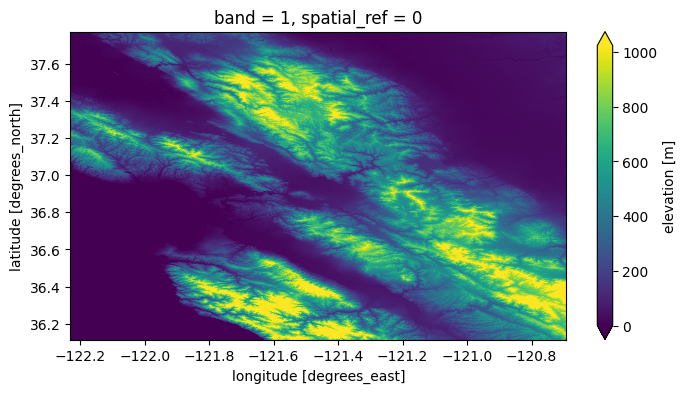

In [102]:
def bounding_box_numpy(points: np.array):
    """
    Find min/max from an N-collection of coordinate pairs, shape = (N, 2), using 
    numpy's min/max along the collection-axis 
    """
    return np.array((points.min(axis=0), points.max(axis=0)))

def get_bb_from_lat_long(lat_longs,diff=1):
    distance = np.sqrt(diff/2)
    up = np.array((distance,distance,0))
    down = np.array((distance,-distance,0))
    left = np.array((-distance,distance,0))
    right = np.array((-distance,-distance,0))
    all_points = np.vstack((lat_longs+up,lat_longs+down,lat_longs+left,lat_longs+right))
    return bounding_box_numpy(all_points)
    
bbox = get_bb_from_lat_long(all_lat_longs)
bbox = bbox[:,0:2].flatten()
bbox = (bbox[0],bbox[1],bbox[2],bbox[3])
dem_res = py3dep.check_3dep_availability(bbox)
print(dem_res)
assert(dem_res["30m"])
res = 30
dem = py3dep.get_dem(bbox, res)

fig, ax = plt.subplots(figsize=(8, 4), dpi=100)
_ = dem.plot(ax=ax, robust=True)


In [261]:
step = 50
pv.set_jupyter_backend('trame')
points = []
index = 0
for label, content in dem.to_pandas().items():
    index=index+1
    if index%step != 0:
        continue
    long = label
    diffs = content.to_numpy()
    lats = np.array(content.index)
    longs = np.zeros(lat.shape)
    longs[:] = label
    verts = get_cartesian(lat=lats,lon=longs,R = 6371,diff=diffs)    
    points.append(verts[::step])
verts = np.vstack((points))-center
print(verts.shape)
topo = pv.PolyData(verts)
# topo.plot()
both = pv.MultiBlock()
both.append(meshes)
both.append(topo)
both.plot()

(13200, 3)


Widget(value='<iframe src="http://localhost:49172/index.html?ui=P_0x28cf23a8050_29&reconnect=auto" class="pyvi…